# **Fraud Detection Using MLOps, NLP, and GANs**

##**Introduction**
In this project, we aim to build and deploy a fraud detection model using both real and synthetic transaction data. The synthetic data will be generated using Generative Adversarial Networks (**GANs**), which helps augment the available fraud data for training. This project will also incorporate **MLOps** tools, such as **MLflow**, to manage and track the models through their lifecycle. Finally, we will document and present the findings through a final report.

This notebook covers the following tasks:
*   Dataset **EDA**
*   Using different classificationnMachine learning models
*   Using **MLflow** to track and manage fraud detection models.
*   Importing **Hugging face** Text fraud data to do **NLP** for fraud detection
*   Implementing a GAN to generate synthetic transaction data.
*   Documenting the results and deploying the fraud detection model.







##**1. Data Exploration and Preprocessing**

##Installing  necessary packages

In [ ]:
!pip install category_encoders
!pip install mlflow
!pip install xgboost
!pip install pyngrok
!pip install torch torchvision
!pip install lightgbm

In [ ]:
!pip install imbalanced-learn

##Importing necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderInsufficientPrivileges
import time
from google.colab import drive
import os
import joblib
import zipfile
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
# from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import mlflow
import mlflow.sklearn
from pyngrok import ngrok
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow.pytorch

##Loading the fraud detection dataset.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import pandas as pd
# dftrain = pd.read_csv('/content/drive/MyDrive/fraud_detection_data/train_data.csv', engine='python')
# dftest = pd.read_csv('/content/drive/MyDrive/fraud_detection_data/test_data.csv', engine='python')


## Reading Data

In [ ]:
# dftotal=pd.concat([dftrain,dftest],ignore_index=True)

In [ ]:
# dftotal['is_fraud'].value_counts()

## Final Extracted Dataset

In [ ]:
# # Step 1: Extract fraud rows
# dfFraud = dftotal[dftotal['is_fraud']==1]
# # Step 2: Calculate the number of rows needed to reach 100,000 entries
# remaining_rows = 100000 - len(dfFraud)
# # Step 3: Extract non-fraud rows
# filteredNotFraud = dftotal[dftotal['is_fraud']==0]
# dfNFraud= filteredNotFraud.sample(n=remaining_rows, random_state=42)
# # Step 4: Combine fraud data with the additional non-fraud data
# dataExtracted = pd.concat([dfNFraud, dfFraud], ignore_index=True)
# # Check the final dataset
# print(dataExtracted.shape)

## Saving final extracted dataset

In [ ]:
# dataExtracted.to_csv('/content/drive/MyDrive/fraud_detection_data/dataExtracted.csv', index=False)

##Displaying basic statistics and first few rows.

In [ ]:
dataExtracted = pd.read_csv('/content/drive/MyDrive/fraud_detection_data/dataExtracted.csv')

In [ ]:
dataExtracted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             100000 non-null  int64  
 1   trans_date_trans_time  100000 non-null  object 
 2   cc_num                 100000 non-null  int64  
 3   merchant               100000 non-null  object 
 4   category               100000 non-null  object 
 5   amt                    100000 non-null  float64
 6   first                  100000 non-null  object 
 7   last                   100000 non-null  object 
 8   gender                 100000 non-null  object 
 9   street                 100000 non-null  object 
 10  city                   100000 non-null  object 
 11  state                  100000 non-null  object 
 12  zip                    100000 non-null  int64  
 13  lat                    100000 non-null  float64
 14  long                   100000 non-nul

In [ ]:
dataExtracted.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000
mean,5.362354e+05,4.133904e+17,112.780039,48524.722800,38.561945,-90.121337,8.750173e+04,1.358410e+09,38.560987,-90.124178,0.096510
std,3.693394e+05,1.302895e+18,243.840156,26873.077332,5.059631,13.722710,2.997180e+05,1.823781e+07,5.095931,13.733369,0.295291
min,1.000000e+01,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325377e+09,19.115015,-166.643193,0.000000
25%,2.256282e+05,1.800400e+14,11.030000,25526.000000,34.690200,-96.727000,7.425000e+02,1.342868e+09,34.795845,-96.783342,0.000000
50%,4.622260e+05,3.521417e+15,51.610000,48034.000000,39.390000,-87.456900,2.443000e+03,1.356911e+09,39.396599,-87.377539,0.000000
75%,8.373290e+05,4.634956e+15,95.622500,71960.000000,41.940400,-80.128400,1.968500e+04,1.374348e+09,41.964228,-80.170875,0.000000
max,1.296659e+06,4.992346e+18,22768.110000,99921.000000,66.693300,-67.950300,2.906700e+06,1.388534e+09,67.510267,-66.955996,1.000000


In [ ]:
dataExtracted.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,517683,2019-08-11 19:38:33,4681601008538160,fraud_Hermann and Sons,shopping_pos,50.81,Tammy,Davis,F,77663 Colleen Freeway,...,39.9148,-80.7310,16183,Physiotherapist,1977-08-12,f64003a5726ca99519ef2ad18bce32f5,1344713913,39.238053,-81.728984,0
1,1012042,2020-02-21 13:31:42,4653879239169997,"fraud_Cronin, Kshlerin and Weber",health_fitness,1.97,Monica,Tucker,F,302 Christina Islands,...,37.0581,-86.1938,6841,"Therapist, sports",1999-06-06,f8e25094098b22a8e9dce2670ffe891e,1361453502,36.665575,-85.608885,0
2,581404,2019-09-03 02:39:49,4334230547694630,fraud_Rutherford-Mertz,grocery_pos,100.18,Scott,Martin,M,7483 Navarro Flats,...,43.0172,-111.0292,471,"Education officer, museum",1967-08-02,291160a410748e5bec42d95ae06132ae,1346639989,43.362578,-110.580382,0
3,1094893,2020-03-31 02:39:04,2256234701263057,fraud_Kris-Padberg,shopping_pos,7.67,Christopher,Grimes,M,39631 Dunn Radial,...,43.5103,-72.1334,2971,Charity fundraiser,1948-04-11,df716fe9ce97522bc074d8c93e6e18c2,1364697544,44.312773,-71.555079,0
4,433289,2020-12-05 07:58:57,6011948324228984,"fraud_Towne, Greenholt and Koepp",shopping_net,478.10,Mckenzie,Brooks,F,3872 Matthew Skyway,...,34.1992,-89.3820,297,"Administrator, local government",1961-12-14,c33bcd8c63d50b4fe9c2514c7107e1ba,1386230337,34.362314,-89.623306,0


##Data Preprocessing

<Axes: >

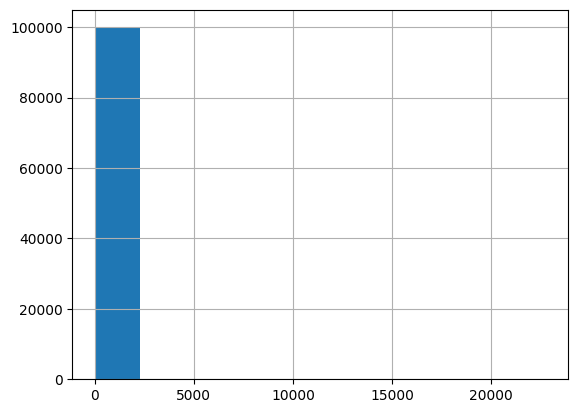

In [ ]:
dataExtracted['amt'].hist()

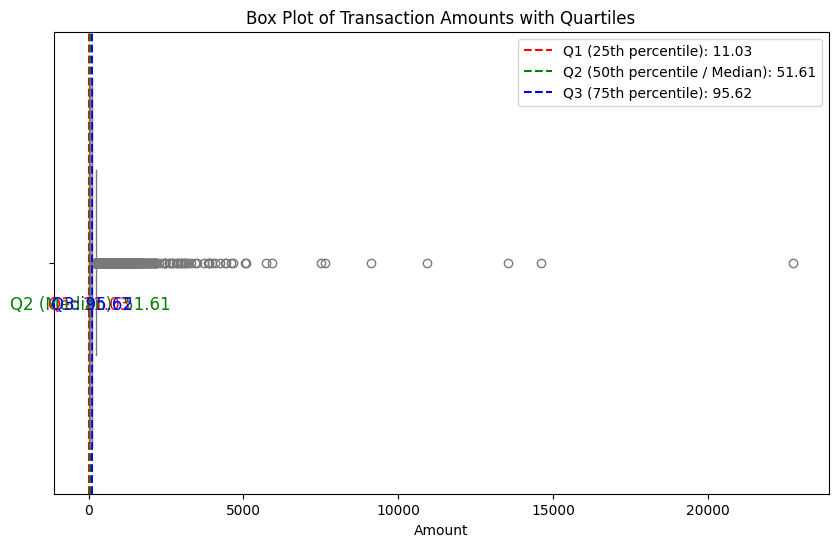

In [ ]:
# Calculate the quartiles
quartiles = np.percentile(dataExtracted['amt'], [25, 50, 75])
q1, q2, q3 = quartiles

# Box plot to visualize distribution and outliers
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x=dataExtracted['amt'], color='lightblue')

# Add vertical lines to indicate quartiles and color them
plt.axvline(x=q1, color='red', linestyle='--', label=f'Q1 (25th percentile): {q1:.2f}')
plt.axvline(x=q2, color='green', linestyle='--', label=f'Q2 (50th percentile / Median): {q2:.2f}')
plt.axvline(x=q3, color='blue', linestyle='--', label=f'Q3 (75th percentile): {q3:.2f}')

# Label the quartiles directly on the plot
plt.text(q1, 0.1, f'Q1: {q1:.2f}', horizontalalignment='center', color='red', fontsize=12)
plt.text(q2, 0.1, f'Q2 (Median): {q2:.2f}', horizontalalignment='center', color='green', fontsize=12)
plt.text(q3, 0.1, f'Q3: {q3:.2f}', horizontalalignment='center', color='blue', fontsize=12)

# Add title and labels
plt.title('Box Plot of Transaction Amounts with Quartiles')
plt.xlabel('Amount')

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
(dataExtracted['amt']>=223).value_counts()

,count
amt,
False,89905
True,10095


In [ ]:
dataExtracted.groupby('is_fraud')['amt'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,90349.0,68.142322,169.799315,1.00,9.640,47.6,82.740,22768.11
1,9651.0,530.661412,391.028873,1.06,240.075,390.0,902.365,1376.04


**Output Interpretation**:

*  'count': Number of transactions in each group (90,349 non-fraud, 9,651 fraud).
*  'mean': The average transaction amount, showing that fraudulent transactions have a much higher mean amount 530.66 than nonfraudulent 68.14.
*  'std': The standard deviation is much larger for fraudulent transactions (391.03 vs. 169.80), indicating a wider variability in fraudulent amounts.
*  'min' and 'max': The minimum and maximum transaction amounts, with non-fraudulent transactions having a much higher max value (22,768.11) compared to fraudulent (1,376.04).
*  Quartiles (25%, 50%, 75%): These give insight into the spread of the data. For example, the 75th percentile of fraudulent transactions (902.37) is significantly higher than for non-fraudulent ones (82.74).


**We prefer not to remove outliers because**:

* The outliers (such as the high max values in non-fraudulent transactions) may be significant to the fraud detection task. Removing them could cause loss of important patterns in the data.
* Fraudulent transactions often have a different distribution with higher amounts, which could reflect legitimate patterns rather than errors or anomalies.

In [ ]:
(dataExtracted['amt']>=1400).value_counts()

,count
amt,
False,99882
True,118


In [ ]:
#converting transaction date to date time datatype
dataExtracted['trans_date_trans_time']= pd.to_datetime(dataExtracted['trans_date_trans_time'])

In [ ]:
#extracting hour from transaction date as it is enough to know the day time status of the transaction , no need for full date so we will drop the date after thatand also unix time no need for it
dataExtracted['hour'] = dataExtracted['trans_date_trans_time'].dt.hour

In [ ]:
dataExtracted['hour'].min()
dataExtracted['hour'].max()

23

In [ ]:
dataExtracted['hour'].isna().sum()

0

In [ ]:
# Define bins for transaction hours
bins = [-1, 5, 11, 17, 24]
labels = ['Early Morning', 'Morning', 'Afternoon', 'Evening']
# Create a new column for binned hours
dataExtracted['Hour_Category'] = pd.cut(dataExtracted['hour'], bins=bins, labels=labels, right=True)

In [ ]:
print(dataExtracted['hour'].describe())

count    100000.000000
mean         12.890930
std           7.137172
min           0.000000
25%           7.000000
50%          14.000000
75%          19.000000
max          23.000000
Name: hour, dtype: float64


In [ ]:
dataExtracted['Hour_Category'].value_counts()
dataExtracted.isnull().sum()

,0
Unnamed: 0,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0


Hour_category Now (after making bins starting from -1) doesn't has nulls

In [ ]:
dataExtracted[dataExtracted['Hour_Category'].isna()]['is_fraud'].value_counts()

,count
is_fraud,


In [ ]:
# drop the hour column
dataExtracted.drop(columns='hour',axis=1,inplace=True)

In [ ]:
# Converting the 'dob' (date of birth) column in the dataset to datetime format using the pd.to_datetime() function.
# to enable date-related operations like calculating age.
# By converting to datetime, we can also ensure consistency when working with date values across the dataset.
dataExtracted['dob']=pd.to_datetime(dataExtracted['dob'])

In [ ]:
# Defining a function 'calculate_age' that calculates a person's age based on their date of birth (born).
# The function compares the current date (retrieved using pd.to_datetime('today')) with the date of birth (born).
# The logic calculates the difference in years, and the additional subtraction handles cases where the person's birthday has not yet occurred this year.
# Then, we apply this function to the 'dob' column in the dataset using the .apply() method, creating a new 'age' column with the calculated ages.
# This allows us to add a new 'age' feature to the dataset, which can be useful in analyzing age-related patterns in fraudulent vs. non-fraudulent transactions
def calculate_age(born):
    today = pd.to_datetime('today')
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

dataExtracted['age'] = dataExtracted['dob'].apply(calculate_age)

In [ ]:
dataExtracted['age'].value_counts()

,count
age,
52,3921
39,3036
37,3026
48,2756
36,2572
...,...
86,255
81,198
92,106


In [ ]:
dataExtracted['age'].describe()

,age
count,100000.000000
mean,50.787500
std,17.516607
min,19.000000
25%,37.000000
50%,49.000000
75%,62.000000
max,99.000000


<Axes: >

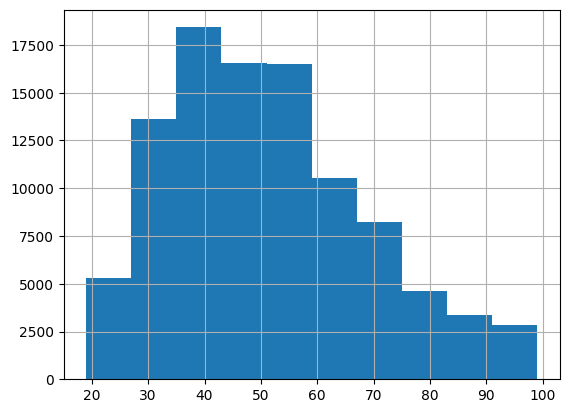

In [ ]:
dataExtracted['age'].hist()

In [ ]:
# Create bins for Age
age_bins = [0, 18, 35, 55, float('inf')]
age_labels = ['Child', 'Young Adult', 'Adult', 'Senior']
dataExtracted['Age_Category'] = pd.cut(dataExtracted['age'], bins=age_bins, labels=age_labels, right=True)
# Drop age column
dataExtracted.drop(columns='age',axis=1,inplace=True)

In [ ]:
dataExtracted['Age_Category'].value_counts(ascending=False)

,count
Age_Category,
Adult,44797
Senior,34851
Young Adult,20352
Child,0


In [ ]:
# sometimes distance from the customer's home location to the merchant's location can prove out to be main reason for fraud, so taking the
# difference of longitude and lattitude of respective columns

dataExtracted["lat_diff"] = abs(dataExtracted.lat - dataExtracted.merch_lat)
dataExtracted["long_diff"] = abs(dataExtracted["long"] - dataExtracted["merch_long"])

In [ ]:
dataExtracted["displacement Km"] = np.sqrt(pow((dataExtracted["lat_diff"]*110),2) + pow((dataExtracted["long_diff"]*110),2))
print(dataExtracted["displacement Km"].describe())
dataExtracted.drop(columns=["lat_diff","long_diff"],axis=1,inplace=True)

count    100000.000000
mean         84.324645
std          31.217965
min           0.069542
25%          62.270902
50%          87.899418
75%         107.507169
max         154.906578
Name: displacement Km, dtype: float64


In [ ]:
# Create bins for Displacement based on the statistics
displacement_bins = [0, 30, 70, 100, 155]
displacement_labels = ['Very Close', 'Close', 'Moderate', 'Far']

dataExtracted['Displacement_Category'] = pd.cut(dataExtracted['displacement Km'], bins=displacement_bins, labels=displacement_labels, right=False)
# Drop displacement Km column
dataExtracted.drop(columns='displacement Km',axis=1,inplace=True)



In [ ]:
print(dataExtracted['Displacement_Category'].value_counts())

Displacement_Category
Far           35223
Moderate      33195
Close         25852
Very Close     5730
Name: count, dtype: int64


In [ ]:
dataExtracted['city_pop'].describe()

,city_pop
count,1.000000e+05
mean,8.750173e+04
std,2.997180e+05
min,2.300000e+01
25%,7.425000e+02
50%,2.443000e+03
75%,1.968500e+04
max,2.906700e+06


In [ ]:
# Define bins for categories based on the statistics
bins = [0, 500, 2500, 20000, 100000, 3000000]
labels = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']  # Custom bin labels

# Create a new column for binned city population
dataExtracted['population_cat'] = pd.cut(dataExtracted['city_pop'], bins=bins, labels=labels, right=False)

# Drop city_population column
dataExtracted.drop(columns='city_pop',axis=1,inplace=True)

In [ ]:
dataExtracted['population_cat'].value_counts()

,count
population_cat,
Small,32753
Medium,24756
Very Small,17692
Very Large,13681
Large,11118


In [ ]:
dataExtracted.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'Hour_Category', 'Age_Category',
       'Displacement_Category', 'population_cat'],
      dtype='object')

In [ ]:
dataExtracted['amt'].unique()

array([  50.81,    1.97,  100.18, ...,  868.09, 1039.42,  766.38])

In [ ]:
# drop useless, unique-values columns
dataExtracted.drop(columns=['Unnamed: 0','trans_date_trans_time','cc_num','merchant','first','last','street', 'city','trans_num','zip',
       'lat', 'long','dob','unix_time','merch_lat', 'merch_long'],axis=1,inplace=True)

In [ ]:
dataExtracted.columns

Index(['category', 'amt', 'gender', 'state', 'job', 'is_fraud',
       'Hour_Category', 'Age_Category', 'Displacement_Category',
       'population_cat'],
      dtype='object')

In [ ]:
dataExtracted['category'].unique()

array(['shopping_pos', 'health_fitness', 'grocery_pos', 'shopping_net',
       'misc_net', 'kids_pets', 'gas_transport', 'entertainment', 'home',
       'food_dining', 'misc_pos', 'grocery_net', 'personal_care',
       'travel'], dtype=object)

In [ ]:
catCols=dataExtracted.select_dtypes(include=['object','category']).columns
catCols

Index(['category', 'gender', 'state', 'job', 'Hour_Category', 'Age_Category',
       'Displacement_Category', 'population_cat'],
      dtype='object')

In [ ]:
dataExtracted.isna().sum()

,0
category,0
amt,0
gender,0
state,0
job,0
is_fraud,0
Hour_Category,0
Age_Category,0
Displacement_Category,0
population_cat,0


## Features encoding

In [ ]:
# use binary encoding to train random-forest to get features importance
features = dataExtracted[['amt','Hour_Category', 'Age_Category', 'Displacement_Category',
                           'state', 'gender', 'population_cat', 'job', 'category']]
target = dataExtracted['is_fraud']

encoder = ce.BinaryEncoder()
features_encoded = encoder.fit_transform(features)

print("\nBinary Encoded DataFrame:")


Binary Encoded DataFrame:


In [ ]:
features_encoded.head()

,amt,Hour_Category_0,Hour_Category_1,Hour_Category_2,Age_Category_0,Age_Category_1,Displacement_Category_0,Displacement_Category_1,Displacement_Category_2,state_0,...,job_3,job_4,job_5,job_6,job_7,job_8,category_0,category_1,category_2,category_3
0,50.81,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1.97,0,1,1,0,1,0,1,1,0,...,0,0,0,0,1,0,0,0,1,0
2,100.18,0,0,1,1,1,0,1,0,0,...,0,0,0,0,1,1,0,0,1,1
3,7.67,0,0,1,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,478.10,0,1,0,1,1,0,1,0,0,...,0,0,0,1,0,1,0,1,0,0


## Split the data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': features_encoded.columns, 'Importance': importances})

# Function to map the encoded columns back to their original feature names
def map_feature_names(feature):
    if 'state_' in feature:
        return 'state'
    elif 'gender_' in feature:
        return 'gender'
    elif 'job_' in feature:
        return 'job'  # Adjusted to 'job'
    elif 'category_' in feature:
        return 'category'
    elif 'Hour_Category_' in feature:
        return 'Hour_Category'
    elif 'Age_Category_' in feature:
        return 'Age_Category'
    elif 'Displacement_Category_' in feature:
        return 'Displacement_Category'
    elif 'population_cat_' in feature:
        return 'population_category'
    else:
        return feature

# Apply the mapping function
feature_importances['Original Feature'] = feature_importances['Feature'].apply(map_feature_names)

# Aggregate the importances
aggregated_importances = feature_importances.groupby('Original Feature')['Importance'].sum().reset_index()

# Sort the aggregated importances for plotting (but keep original index for annotation)
aggregated_importances = aggregated_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the aggregated importances
print(aggregated_importances)
# # Create a DataFrame for feature importances
# feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
# feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# print(feature_importances)

        Original Feature  Importance
0                    amt    0.609374
1               category    0.114563
2                    job    0.074059
3          Hour_Category    0.072823
4                  state    0.045839
5  Displacement_Category    0.025778
6           Age_Category    0.024380
7    population_category    0.021545
8                 gender    0.011639


<ipython-input-58-0b08a17854b0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Original Feature', data=aggregated_importances, palette='viridis')


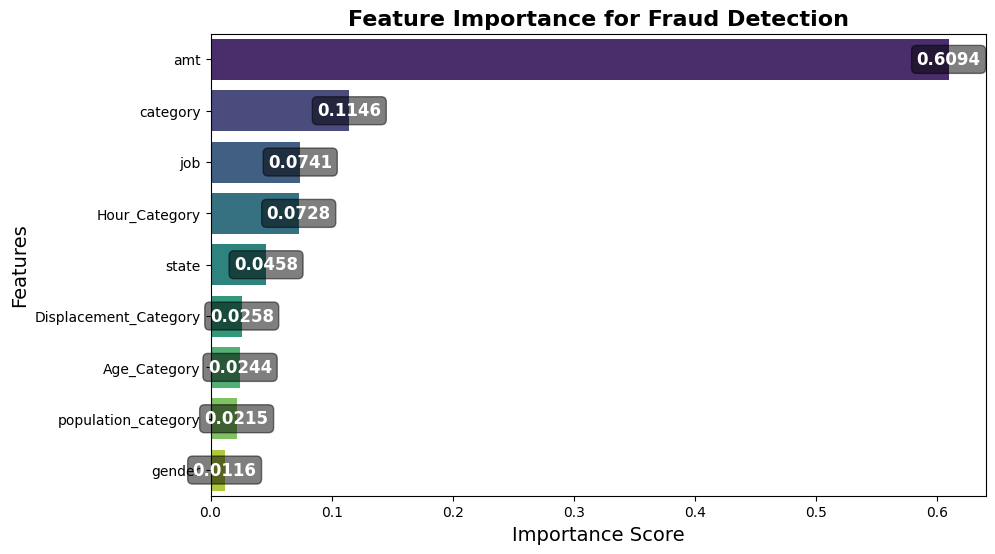

In [ ]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the bar plot for the top features
sns.barplot(x='Importance', y='Original Feature', data=aggregated_importances, palette='viridis')

# Add title and labels
plt.title('Feature Importance for Fraud Detection', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Annotate the bars with their respective importance values
for index, row in aggregated_importances.iterrows():
    # Place the text slightly above the bar
    plt.text(row['Importance'], index,
             f'{row["Importance"]:.4f}',
             color='white',
             ha='center',
             va='center',
             fontsize=12,
             fontweight='bold',
             bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

# Show the plot
plt.show()

From the problem understanding, and the feature importances measures the fraud activity can be most impacted and detected by:

*   Amount (greatest influence).
*    Category
*   job
*   hour(extracted from trans time).
*   State
*   Displacement(distance from the customer's home location to the merchant's location)
*   Age(extracted from dob)

*   city_pop






## MLFlow and models tuning

### Preparing Pipeline



In [ ]:
numeric_features = ['amt']
categorical_features = dataExtracted.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', ce.BinaryEncoder(), categorical_features)
    ]
)

# Create a preprocessing and model pipeline
def get_model_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)])

### Splitting, Encoding and Resampling raw data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
encoded_Xtrain = preprocessor.fit_transform(X_train)  #ndarray
encoded_Xtrain = pd.DataFrame(encoded_Xtrain, columns= features_encoded.columns)
encoded_Xtest = preprocessor.transform(X_test)  #ndarray
encoded_Xtest = pd.DataFrame(encoded_Xtest, columns= features_encoded.columns)

In [ ]:
encoded_Xtrain.head()

,amt,Hour_Category_0,Hour_Category_1,Hour_Category_2,Age_Category_0,Age_Category_1,Displacement_Category_0,Displacement_Category_1,Displacement_Category_2,state_0,...,job_3,job_4,job_5,job_6,job_7,job_8,category_0,category_1,category_2,category_3
0,-0.577329,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.090815,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.145765,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,-0.581937,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
4,-0.103932,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
smote_tomek = SMOTETomek(random_state=42)  # for balancing train data
X_resampled, y_resampled = smote_tomek.fit_resample(encoded_Xtrain, y_train)

In [ ]:
print(len(y_resampled[y_resampled == 1]), len(y_resampled[y_resampled == 0]))

63100 63100


### Training and logging models

In [ ]:
import scipy.sparse as sp

# Initialize variables to store the best recall score and model pipeline
best_recall = 0
best_model_name = None
best_model_pipeline = None

def train_and_log_model(model, model_name, X_train, y_train, X_test, y_test):

    global best_recall, best_model_name, best_model_pipeline
    mlflow.set_experiment("Fraud Detection Models")
    with mlflow.start_run(run_name=model_name):
        # Fit the model
        pipeline = get_model_pipeline(model)
        # pipeline.fit(X_train, y_train)
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.predict(X_test)

        # Log model parameters
        if hasattr(model, 'get_params'):
            params = model.get_params()
            for param, value in params.items():
                mlflow.log_param(param, value)

    # Get classification metrics
        report = classification_report(y_test, y_pred, output_dict=True)

        # Prepare a dictionary to hold the metrics
        metrics = {
            "precision_nonFraud": report['0']['precision'],
            "recall_nonFraud": report['0']['recall'],
            "f1_nonFraud": report['0']['f1-score'],
            "precision_fraud": report['1']['precision'],
            "recall_fraud": report['1']['recall'],
            "f1_fraud": report['1']['f1-score'],
            "accuracy": report['accuracy']
        }

        # Log all metrics at once using the dictionary
        mlflow.log_metrics(metrics)
        print(f"{model_name} logged successfully with metrics: {metrics}")

        # Log the model itself and the pipeline
        mlflow.sklearn.log_model(pipeline, model_name+'_Pipeline')
        mlflow.sklearn.log_model(model, model_name+"_model")


        print(f"{model_name} logged successfully.")

          # Check if the current model has the best recall for the fraud class (class '1')
        current_recall = metrics["recall_fraud"]
        if current_recall > best_recall:
            best_recall = current_recall
            best_model_name = model_name

In [ ]:
from sklearn.metrics import recall_score

# List of models to try
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth = 10, n_jobs=-1)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100)),
    ('Linear SVC', LinearSVC(max_iter=1000)),
    ('XGBoost', XGBClassifier(scale_pos_weight=10, n_estimators=100, n_jobs=-1)),
    ('LightGBM', LGBMClassifier(n_estimators=100, n_jobs=-1))
]

best_recall = 0  # To track the best recall score
best_model_pipeline = None
best_model_name = None

for model_name, model in models:

    train_and_log_model(model, model_name, X_resampled, y_resampled, encoded_Xtest, y_test)
    print(f"Training {model_name}...")

2024/10/27 12:17:59 INFO mlflow.tracking.fluent: Experiment with name 'Fraud Detection Models' does not exist. Creating a new experiment.


Logistic Regression logged successfully with metrics: {'precision_nonFraud': 0.9714623989548461, 'recall_nonFraud': 0.8770410231838118, 'f1_nonFraud': 0.9218401937046005, 'precision_fraud': 0.3941155103523429, 'recall_fraud': 0.7563611014290693, 'f1_fraud': 0.5182089552238806, 'accuracy': 0.8655}


2024/10/27 12:18:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/27 12:18:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression logged successfully.
Training Logistic Regression...
Random Forest logged successfully with metrics: {'precision_nonFraud': 0.9802686664967782, 'recall_nonFraud': 0.9924809258781467, 'f1_nonFraud': 0.9863369963369963, 'precision_fraud': 0.919399446858949, 'recall_fraud': 0.811084001394214, 'f1_fraud': 0.8618518518518519, 'accuracy': 0.9751333333333333}


2024/10/27 12:18:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/27 12:18:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest logged successfully.
Training Random Forest...
Gradient Boosting logged successfully with metrics: {'precision_nonFraud': 0.9833235164187896, 'recall_nonFraud': 0.9845195532785375, 'f1_nonFraud': 0.9839211713785799, 'precision_fraud': 0.8519040902679831, 'recall_fraud': 0.8421052631578947, 'f1_fraud': 0.8469763365468886, 'accuracy': 0.9709}


2024/10/27 12:19:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/27 12:19:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting logged successfully.
Training Gradient Boosting...
Linear SVC logged successfully with metrics: {'precision_nonFraud': 0.9714437237384245, 'recall_nonFraud': 0.877704470900446, 'f1_nonFraud': 0.9221981256293084, 'precision_fraud': 0.39529797703663205, 'recall_fraud': 0.7560125479261066, 'f1_fraud': 0.5191479176639541, 'accuracy': 0.8660666666666667}


2024/10/27 12:19:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/27 12:19:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Linear SVC logged successfully.
Training Linear SVC...
XGBoost logged successfully with metrics: {'precision_nonFraud': 0.9952870768655321, 'recall_nonFraud': 0.9807600162176109, 'f1_nonFraud': 0.9879701481453979, 'precision_fraud': 0.8401225114854518, 'recall_fraud': 0.9560822586266992, 'f1_fraud': 0.8943593087707857, 'accuracy': 0.9784}


2024/10/27 12:19:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/27 12:19:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost logged successfully.
Training XGBoost...
[LightGBM] [Info] Number of positive: 63100, number of negative: 63100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 126200, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM logged successfully with metrics: {'precision_nonFraud': 0.98840154156726, 'recall_nonFraud': 0.9925546422911061, 'f1_nonFraud': 0.9904737384140062, 'precision_fraud': 0.9266787658802178, 'recall_fraud': 0.8898570930637852, 'f1_fraud': 0.9078947368421053, 'accuracy': 0.9827333333333333}


2024/10/27 12:19:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/27 12:19:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM logged successfully.
Training LightGBM...


In [ ]:
# Set your authtoken here
NGROK_AUTH_TOKEN = "2nwbSp8iiDWOMgSCMyI7HY8wiw5_7RFcptB6fKAXTM5couZRt"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Run MLflow UI
get_ipython().system_raw("mlflow ui --port 5000 &")  # Start MLflow on port 5000

# ngrok command with HTTP protocol and port
public_url = ngrok.connect(5000, "http")  # specify both port and protocol
print(f"MLflow Tracking UI: {public_url}")

# Kill any existing ngrok processes before starting a new one
# for line in os.popen("ps aux | grep ngrok | grep -v grep").readlines():
#     pid = int(line.split()[1])
#     try:
#         os.kill(pid, signal.SIGKILL)  # or signal.SIGTERM
#         print(f"Killed existing ngrok process with PID {pid}")
#     except ProcessLookupError:
#         pass  # Process might have already terminated

MLflow Tracking UI: NgrokTunnel: "https://680e-34-16-72-45.ngrok-free.app" -> "http://localhost:5000"


### Testing best model

In [ ]:
fraud_data = dataExtracted[dataExtracted['is_fraud']==1].drop(columns='is_fraud',axis=1)

In [ ]:
# Test the best model (xgboost)
model = joblib.load('model.pkl')
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
print(len(y_test[y_test== 0]), len(y_test[y_test== 1]))

27131 2869


In [ ]:
y_pred = model.predict(encoded_Xtest)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     27131
           1       0.84      0.95      0.89      2869

    accuracy                           0.98     30000
   macro avg       0.92      0.97      0.94     30000
weighted avg       0.98      0.98      0.98     30000



##GANS



GANs optimization: wider gen, DCGAN, loss func, Wasserstein GAN with gradient penalty (WGAN-GP), large batch, more epochs

###  Conditional GANs

In [ ]:
!pip install ctgan

In [ ]:
# real_data = pd.concat([X_resampled, y_resampled], axis = 1) # real_data after encoding, it should has the features and target

In [ ]:
## take only 10,000 samples out of 126,000 samples
# real_data_sample = pd.concat([real_data[real_data['is_fraud'] == 1].iloc[:5000], real_data[real_data['is_fraud'] == 0].iloc[:5000]], axis= 0)
real_data_sample = pd.concat([dataExtracted[dataExtracted['is_fraud'] == 1], dataExtracted[dataExtracted['is_fraud'] == 0].iloc[:10000]], axis= 0) #data before encoding
real_data_sample = real_data_sample.sample(frac=1).reset_index(drop=True) # for shuffling
real_data_sample.head(10)

,category,amt,gender,state,job,is_fraud,Hour_Category,Age_Category,Displacement_Category,population_cat
0,misc_pos,6.77,F,SC,Museum/gallery conservator,0,Afternoon,Young Adult,Close,Very Small
1,shopping_net,1065.32,M,TX,Tax adviser,1,Evening,Young Adult,Close,Very Large
2,grocery_pos,172.60,F,MS,Medical physicist,0,Morning,Senior,Far,Small
3,grocery_net,36.56,F,NY,Chartered loss adjuster,0,Early Morning,Adult,Moderate,Medium
4,misc_pos,1.77,F,OH,Professor Emeritus,0,Morning,Senior,Far,Very Small
5,grocery_pos,104.90,M,MT,Chartered loss adjuster,0,Morning,Adult,Far,Small
6,shopping_net,925.28,F,PA,Theme park manager,1,Evening,Young Adult,Close,Small
7,misc_net,1.63,M,TX,Optometrist,0,Early Morning,Adult,Moderate,Medium
8,grocery_pos,306.63,F,KY,"Development worker, international aid",1,Early Morning,Senior,Moderate,Very Small
9,gas_transport,20.00,M,AK,"Engineer, civil (consulting)",1,Morning,Senior,Close,Very Small


In [ ]:
# Pop the target to move it to a variable
col_to_move = real_data_sample.pop('is_fraud')

# Append it back to the DataFrame
real_data_sample['is_fraud'] = col_to_move
real_data_sample.head(50)

,category,amt,gender,state,job,Hour_Category,Age_Category,Displacement_Category,population_cat,is_fraud
0,misc_pos,6.77,F,SC,Museum/gallery conservator,Afternoon,Young Adult,Close,Very Small,0
1,shopping_net,1065.32,M,TX,Tax adviser,Evening,Young Adult,Close,Very Large,1
2,grocery_pos,172.60,F,MS,Medical physicist,Morning,Senior,Far,Small,0
3,grocery_net,36.56,F,NY,Chartered loss adjuster,Early Morning,Adult,Moderate,Medium,0
4,misc_pos,1.77,F,OH,Professor Emeritus,Morning,Senior,Far,Very Small,0
5,grocery_pos,104.90,M,MT,Chartered loss adjuster,Morning,Adult,Far,Small,0
6,shopping_net,925.28,F,PA,Theme park manager,Evening,Young Adult,Close,Small,1
7,misc_net,1.63,M,TX,Optometrist,Early Morning,Adult,Moderate,Medium,0
8,grocery_pos,306.63,F,KY,"Development worker, international aid",Early Morning,Senior,Moderate,Very Small,1
9,gas_transport,20.00,M,AK,"Engineer, civil (consulting)",Morning,Senior,Close,Very Small,1


In [ ]:
from ctgan import CTGAN
from ctgan import load_demo

ctgan = CTGAN(epochs=150, verbose= True)

In [ ]:
ctgan.fit(real_data_sample, discrete_columns=['state', 'gender', 'job', 'category', 'Hour_Category', 'Age_Category', 'Displacement_Category', 'population_cat'])

Gen. (-0.64) | Discrim. (0.04):  89%|████████▉ | 134/150 [34:29<04:30, 16.92s/it]

In [ ]:
ctgan.save('ctgan_model.pkl')

In [ ]:
# Create synthetic data
synthetic_data = ctgan.sample(30000)
# synthetic_data.head()

In [ ]:
synthetic_data[synthetic_data['is_fraud']==1].shape

(13459, 10)

In [ ]:
pipeline = joblib.load('model_pipeline.pkl')
y_pred = pipeline.predict(synthetic_data.iloc[:,:-1])
y_test = synthetic_data.iloc[:,-1]
print(classification_report(y_test, y_pred)) #70 epoch

In [ ]:
synthetic_fraud = synthetic_data[synthetic_data['is_fraud']==1]
new_balanced_data = pd.concat([dataExtracted[dataExtracted['is_fraud'] == 1], dataExtracted[dataExtracted['is_fraud'] == 0].iloc[:23000]], axis= 0)
new_balanced_data = pd.concat([new_balanced_data, synthetic_fraud], axis=0)
new_balanced_data = new_balanced_data.sample(frac=1).reset_index(drop=True)
new_balanced_data.head()

,category,amt,gender,state,job,is_fraud,Hour_Category,Age_Category,Displacement_Category,population_cat
0,misc_net,1180.840473,F,NY,Fisheries officer,1,Evening,Young Adult,Moderate,Small
1,shopping_net,900.060000,M,MO,Tourist information centre manager,1,Evening,Adult,Far,Small
2,shopping_pos,814.961790,F,NY,"Buyer, retail",1,Early Morning,Senior,Moderate,Medium
3,grocery_pos,55.270000,M,KY,Stage manager,0,Morning,Senior,Close,Medium
4,entertainment,66.320000,M,MN,Land/geomatics surveyor,0,Evening,Young Adult,Moderate,Small


In [ ]:
new_balanced_data['is_fraud'].value_counts()

,count
is_fraud,
1,23110
0,23000


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_balanced_data.drop(columns=['is_fraud']), new_balanced_data['is_fraud'], test_size=0.3, random_state=42)
encoded_Xtrain = preprocessor.fit_transform(X_train)  #ndarray
encoded_Xtrain = pd.DataFrame(encoded_Xtrain, columns= features_encoded.columns)
encoded_Xtest = preprocessor.transform(X_test)  #ndarray
encoded_Xtest = pd.DataFrame(encoded_Xtest, columns= features_encoded.columns)

In [ ]:
xgboost = XGBClassifier(scale_pos_weight=10, n_estimators=100, n_jobs=-1)
xgboost.fit(encoded_Xtrain, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgboost.predict(encoded_Xtest)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      6830
           1       0.87      0.97      0.92      7003

    accuracy                           0.91     13833
   macro avg       0.92      0.91      0.91     13833
weighted avg       0.92      0.91      0.91     13833



Training XGBoost model with augmented dataset using GANs synthetic data improved recall of underrepresented class 'fraud' from 95% to 97%

### Build vanilla model

vanilla GANs were built, but multiple archintectures underfitted.

In [ ]:
# # Generator Model
# class Generator(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#           nn.Linear(input_dim, 256),  # Increased from 128
#           nn.LeakyReLU(0.2),
#           nn.BatchNorm1d(256),  # Add BatchNorm
#           nn.Linear(256, 512),
#           nn.LeakyReLU(0.2),
#           nn.BatchNorm1d(512),
#           nn.Linear(512, 1024),  # Increased from 512
#           nn.LeakyReLU(0.2),
#           nn.BatchNorm1d(1024),
#           nn.Linear(1024, 512),
#           nn.LeakyReLU(0.2),

#           nn.BatchNorm1d(512),
#           nn.Linear(512, 256),
#           nn.LeakyReLU(0.2),
#           nn.BatchNorm1d(256),
#           nn.Linear(256, output_dim),
#           nn.Tanh()
#       )

#     def forward(self, x):
#         return self.model(x)

In [ ]:
# # Discriminator Model
# class Discriminator(nn.Module):
#     def __init__(self, input_dim):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(output_dim, 512),
#             nn.LeakyReLU(0.2),
#             nn.Linear(512, 512),
#             nn.LeakyReLU(0.2),
#             nn.Linear(512, 255),
#             nn.LeakyReLU(0.2),
#             nn.Linear(255, 128),
#             nn.LeakyReLU(0.2),
#             nn.Linear(128, 128),
#             nn.LeakyReLU(0.2),
#             nn.Linear(128, 1),
#             nn.Sigmoid()  # Output probability of being real or fake
#         )

#     def forward(self, x):
#         return self.model(x)

In [ ]:
# output_dim = transformed_fraud_data.shape[1]  # Dimension of fraud data features

# # Hyperparameters
# input_dim = 160
# batch_size = 64
# epochs = 800
# lr = 0.0005
# # lr_d = 0.0004
# generator_updates = 3       # How many times to update the generator per discriminator update
# # decay_steps = 1000  # Number of steps before decay
# # decay_rate_g = 0.4   # Decay rate for generator
# # decay_rate_d = 0.8   # Decay rate for generator

# # def get_learning_rate(epoch, lr, drate):
# #     return lr * (drate ** (epoch // decay_steps))

# # Initialize models
# generator = Generator(input_dim, output_dim)
# discriminator = Discriminator(output_dim)

# # Loss function
# criterion = nn.BCELoss()

# # Optimizers
# g_optimizer = optim.Adam(generator.parameters(), lr=lr)
# d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

the generator is underfitting while discriminator is very strong
* increased the input_dim for more noise
* increased generator lr and decreased discriminator lr
* Updating generator multiple times per discriminator update

### Logging and training

In [ ]:
# mlflow.set_experiment("GAN for Fraud Detection")

# with mlflow.start_run():
#     # Training loop
#     for epoch in range(epochs):
#         # 1. Train Discriminator

#         # Sample real data from the fraud dataset
#         idx = np.random.choice(transformed_fraud_data.shape[0], batch_size, replace=False)
#         real_data = transformed_fraud_data.iloc[idx]
#         real_data = torch.tensor(real_data.values, dtype=torch.float32)

#         # Generate fake data
#         noise = torch.randn(batch_size, input_dim)
#         fake_data = generator(noise)

#         # Labels for real and fake data
#         real_labels = torch.ones(batch_size, 1)
#         fake_labels = torch.zeros(batch_size, 1)

#         # Train on real data
#         d_optimizer.zero_grad()
#         # lr = get_learning_rate(epoch, lr_d, decay_rate_d)

#         # for param_group in d_optimizer.param_groups:
#         #   param_group['lr'] = lr

#         real_predictions = discriminator(real_data)
#         real_loss = criterion(real_predictions, real_labels)

#         # Train on fake data
#         fake_predictions = discriminator(fake_data.detach())  # Detach to avoid backprop through the generator
#         fake_loss = criterion(fake_predictions, fake_labels)

#         # Total loss for the discriminator
#         d_loss = real_loss + fake_loss
#         d_loss.backward()
#         d_optimizer.step()

#         # 2. Train Generator
#         for _ in range(generator_updates):
#           # Generate fake data again
#           fake_data = generator(noise)

#           # We want the generator to fool the discriminator, so labels are real (1)
#           g_optimizer.zero_grad()
#           # lr = get_learning_rate(epoch, lr_g, decay_rate_g)
#           # for param_group in g_optimizer.param_groups:
#           #   param_group['lr'] = lr
#           predictions = discriminator(fake_data)
#           g_loss = criterion(predictions, real_labels)
#           g_loss.backward()
#           g_optimizer.step()

#         # Print losses at intervals
#         if epoch % 20 == 0:
#             print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
#             mlflow.log_metric("d_loss", d_loss.item(), step=epoch)
#             mlflow.log_metric("g_loss", g_loss.item(), step=epoch)
#     # Log the model
#     mlflow.pytorch.log_model(generator, "generator_model")
#     mlflow.pytorch.log_model(discriminator, "discriminator_model")
#     mlflow.log_metrics({"epochs": epochs,
#                        "batch_size": batch_size,
#                       #  "g_learning rate":lr_g,
#                       #   "d_learning rate":lr_d,
#                        "input_diminsions": input_dim})

In [ ]:
# # Function to generate synthetic fraud data
# def generate_synthetic_data(generator, num_samples=2000, input_dim=100, real_data_columns=None):
#     # Generate noise as input to the generator
#     noise = torch.randn(num_samples, input_dim)

#     # Generate synthetic data
#     synthetic_data = generator(noise).detach().numpy()  # Detach from graph and convert to NumPy array

#     # Convert the synthetic data to a DataFrame
#     if real_data_columns is not None:
#         # Use the columns from the real data
#         df_synthetic = pd.DataFrame(synthetic_data, columns=real_data_columns)
#     else:
#         # Use generic column names if no real data columns are provided
#         columns = [f"Feature_{i}" for i in range(synthetic_data.shape[1])]
#         df_synthetic = pd.DataFrame(synthetic_data, columns=columns)

#     return df_synthetic

In [ ]:
# real_data_columns = transformed_fraud_data.columns
# num_samples = 5000  # Number of synthetic samples to generate

# synthetic_fraud_df = generate_synthetic_data(generator, num_samples=num_samples, input_dim=input_dim, real_data_columns=real_data_columns)

# # Print the first few rows of the generated synthetic data
# print(synthetic_fraud_df.head())

# Optionally: save to CSV
# synthetic_df.to_csv("synthetic_fraud_data.csv", index=False)

In [ ]:
# synthetic_fraud_df.shape